In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Functions.Preprocess import events_to_df_vert, scale_shift_feats, for_nn
from Functions.Models import cnn, lstm, lstm_big, train
from Functions.Compare import compareAB
analysis_path = "Analysis/Rave/"
data_path = "Data/Rave/"

Wall time: 8.21 s


In [61]:
%%time
max_ev = int(1e5)
n_constits = 50
sort = False
trunc = False

B_jet_path = data_path + "jet_level_vert/bb1.txt"
S_jet_path = data_path + "jet_level_vert/dark1.txt"
B_event_path = data_path + "event_level_vert/bb1.txt"
S_event_path = data_path + "event_level_vert/dark1.txt"

B_jet = events_to_df_vert(B_jet_path, label=0, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc)
S_jet= events_to_df_vert(S_jet_path, label=1, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc) 
B_event = events_to_df_vert(B_event_path, label=0, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc)
S_event= events_to_df_vert(S_event_path, label=1, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc) 

# Shorten background datatframe to same length as signal
B_jet = B_jet[:len(S_jet)]
S_jet = S_jet[:len(B_jet)]
B_event = B_event[:len(S_event)]
S_event = S_event[:len(B_event)]

print("Number of background jets (event) = ", len(B_event))
print("Number of signal jets (event) = ", len(S_event))
print("Number of background jets (jet) = ", len(B_jet))
print("Number of signal jets = (jet) ", len(S_jet))

Number of background jets (event) =  14602
Number of signal jets (event) =  14602
Number of background jets (jet) =  14234
Number of signal jets = (jet)  14234
Wall time: 22.8 s


In [39]:
B_jet.head()

,Event,Jet,MET,jet_PT,jet_Eta,jet_Phi,n_vert,track_PT,track_Eta,track_Phi,track_D0,track_DZ,vert_x,vert_y,vert_z,vert_chisq,label,vert_mult
0,1,1,68.46680,153.974,0.813769,0.462871,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[5.89593, 1.18561, 1.51473, 4.78256, 9.2728, 2...","[0.721211, 0.356514, 0.727335, 0.731937, 0.747...","[0.537924, 0.659866, 0.402486, 0.385235, 0.404...","[0.0190754, 0.00532463, 0.0358291, 0.0232747, ...","[0.0342733, 0.0398092, 0.0683764, 0.00171282, ...","[0.0774948, 0.0774948, 0.0774948, 0.0774948, 0...","[0.0127862, 0.0127862, 0.0127862, 0.0127862, 0...","[0.0659651, 0.0659651, 0.0659651, 0.0659651, 0...","[24.3943, 24.3943, 24.3943, 24.3943, 24.3943, ...",0,1
1,2,1,15.90340,152.063,-1.529420,0.692719,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, ...","[4.6953, 1.37067, 4.53127, 5.80331, 5.60762, 1...","[-1.57702, -1.68397, -1.54227, -1.51327, -1.70...","[0.597367, 0.704351, 0.62883, 0.579408, 0.5957...","[0.171365, 0.106849, 0.0799974, 0.0339247, 0.0...","[0.19688, 0.134787, 0.00081359, -0.00490891, -...","[-0.123512, -0.123512, -0.123512, -0.123512, -...","[-0.143565, -0.143565, -0.143565, -0.143565, -...","[0.406993, 0.406993, 0.406993, 0.406993, 0.406...","[9.04068, 9.04068, 9.04068, 9.04068, 9.04068, ...",0,2
2,5,2,5.44335,152.909,0.732531,2.773680,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...","[1.79563, 4.47623, 41.5623, 1.11461, 1.00867, ...","[0.555598, 0.757302, 0.772171, 0.371874, 0.935...","[2.4351, 2.72961, 2.74372, 3.04374, 3.09264, 2...","[0.140527, 0.199934, 0.0966911, 0.100652, 0.06...","[-0.146683, 0.0374339, -0.122977, -0.0855012, ...","[-0.186383, -0.186383, -0.186383, -0.186383, -...","[-0.0310774, -0.0310774, -0.0310774, -0.031077...","[-0.00238446, -0.00238446, -0.00238446, -0.002...","[10.5702, 10.5702, 10.5702, 10.5702, 10.5702, ...",0,2
3,6,1,37.38050,147.975,1.324040,1.525620,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[12.219, 4.71805, 28.6695, 17.1879, 7.39778, 2...","[1.28914, 1.36836, 1.29653, 1.30455, 1.29761, ...","[1.53673, 1.62344, 1.55285, 1.55417, 1.58661, ...","[0.0486232, 0.134841, 0.017549, 0.0135562, 0.1...","[0.215376, 0.246821, 0.0832336, 0.00568248, 0....","[-0.0108906, -0.0108906, -0.0108906, -0.010890...","[0.159247, 0.159247, 0.159247, 0.159247, 0.159...","[0.244397, 0.244397, 0.244397, 0.244397, 0.244...","[20.635, 20.635, 20.635, 20.635, 20.635, 20.63...",0,2
4,8,1,27.19790,152.460,0.636567,2.553070,"[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0]","[1.16634, 4.27945, 10.1763, 60.8902, 12.3182, ...","[0.564434, 0.601945, 0.606724, 0.617576, 0.584...","[2.92971, 2.48706, 2.60373, 2.53183, 2.52729, ...","[0.112784, 0.0940756, 0.0157328, 0.140737, 0.2...","[0.0781685, 0.0698677, -0.00072533, -0.0116302...","[-0.097059, -0.097059, -0.097059, -0.097059, -...","[0.0902694, 0.0902694, 0.0902694, 0.0902694, 2...","[0.0983726, 0.0983726, 0.0983726, 0.0983726, 2...","[2.88559, 2.88559, 2.88559, 2.88559, 0.889949,...",0,2


In [40]:
B_event.head()

,Event,Jet,MET,jet_PT,jet_Eta,jet_Phi,n_vert,track_PT,track_Eta,track_Phi,track_D0,track_DZ,vert_x,vert_y,vert_z,vert_chisq,label,vert_mult
0,1,1,68.46680,153.974,0.813769,0.462871,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4.78256, 9.2728, 5.89593, 1.18561, 1.51473, 1...","[0.731937, 0.747845, 0.721211, 0.356514, 0.727...","[0.385235, 0.404038, 0.537924, 0.659866, 0.402...","[0.0232747, 0.0274344, 0.0190754, 0.00532463, ...","[0.00171282, -0.0058832, 0.0342733, 0.0398092,...","[-0.013326, -0.013326, -0.013326, -0.013326, -...","[-0.0125239, -0.0125239, -0.0125239, -0.012523...","[-0.00593823, -0.00593823, -0.00593823, -0.005...","[108.416, 108.416, 108.416, 108.416, 108.416, ...",0,3
1,2,1,15.90340,152.063,-1.529420,0.692719,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0]","[5.80331, 4.53127, 5.60762, 1.37067, 4.6953, 1...","[-1.51327, -1.54227, -1.7058, -1.68397, -1.577...","[0.579408, 0.62883, 0.595702, 0.704351, 0.5973...","[0.0339247, 0.0799974, 0.0112791, 0.106849, 0....","[-0.00490891, 0.00081359, -0.117297, 0.134787,...","[-0.00129054, -0.00129054, -0.00129054, -0.001...","[-0.00894006, -0.00894006, -0.00894006, -0.008...","[0.0219864, 0.0219864, 0.0219864, 0.0219864, 0...","[46.6023, 46.6023, 46.6023, 46.6023, 46.6023, ...",0,2
2,5,2,5.44335,152.909,0.732531,2.773680,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...","[1.00867, 1.11461, 41.5623, 1.79563, 4.47623, ...","[0.935457, 0.371874, 0.772171, 0.555598, 0.757...","[3.09264, 3.04374, 2.74372, 2.4351, 2.72961, 2...","[0.0674936, 0.100652, 0.0966911, 0.140527, 0.1...","[0.0214516, -0.0855012, -0.122977, -0.146683, ...","[0.0166873, 0.0166873, 0.0166873, 0.0166873, 0...","[-0.00887233, -0.00887233, -0.00887233, -0.008...","[-0.00455895, -0.00455895, -0.00455895, -0.004...","[53.0468, 53.0468, 53.0468, 53.0468, 53.0468, ...",0,3
3,6,1,37.38050,147.975,1.324040,1.525620,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[17.1879, 34.2435, 18.748, 28.6695, 0.452454, ...","[1.30455, 1.32618, 1.33398, 1.29653, 0.804397,...","[1.55417, 1.53885, 1.54321, 1.55285, 1.82006, ...","[0.0135562, 0.0333339, 0.0506487, 0.017549, 0....","[0.00568248, -0.100172, -0.0963799, 0.0832336,...","[-0.0128364, -0.0128364, -0.0128364, -0.012836...","[0.00798444, 0.00798444, 0.00798444, 0.0079844...","[-0.0193441, -0.0193441, -0.0193441, -0.019344...","[62.0454, 62.0454, 62.0454, 62.0454, 62.0454, ...",0,2
4,8,1,27.19790,152.460,0.636567,2.553070,"[1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0]","[10.1763, 4.27945, 1.16634, 60.8902, 12.3182, ...","[0.606724, 0.601945, 0.564434, 0.617576, 0.584...","[2.60373, 2.48706, 2.92971, 2.53183, 2.52729, ...","[0.0157328, 0.0940756, 0.112784, 0.140737, 0.2...","[-0.00072533, 0.0698677, 0.0781685, -0.0116302...","[-0.0275064, -0.0275064, -0.0275064, -0.027506...","[0.0134657, 0.0134657, 0.0134657, 0.0134657, 2...","[0.0226025, 0.0226025, 0.0226025, 0.0226025, 2...","[41.2279, 41.2279, 41.2279, 41.2279, 0.889949,...",0,2


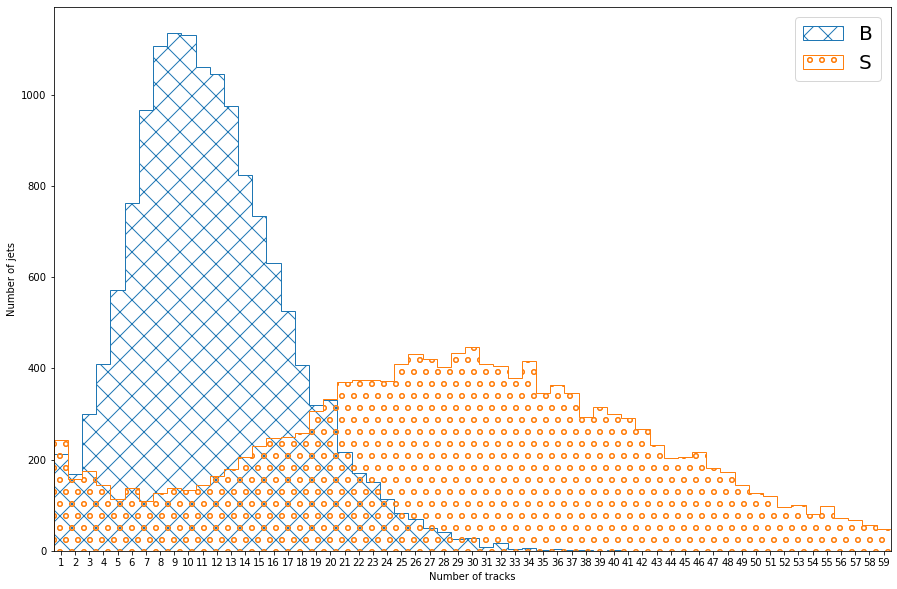

In [41]:
# Track multiplicity
fname = "track_multiplicity"
vertex = 'event' # 'event' or 'jet'
x_max = 60
bins = np.arange(0.5,x_max+0.5,1)
ticks =np.arange(1,x_max);
cutoff = 3

if vertex == 'event':
    B = B_event.copy()
    S = S_event.copy()
elif vertex == 'jet':
    B = B_jet.copy()
    S = S_jet.copy()

B['mult'] = B.track_PT.map(lambda x: len(x))
S['mult'] = S.track_PT.map(lambda x: len(x))
plt.hist(B.mult, histtype="step",hatch="x", bins=bins);
plt.hist(S.mult, histtype="step",hatch="o", bins=bins);
plt.legend(["B","S"],fontsize=20)
plt.xticks(ticks)
plt.xlim([0.5,x_max-0.5])
plt.ylabel("Number of jets")
plt.xlabel("Number of tracks")
plt.gcf().set_size_inches(15,10)
plt.savefig(fname=analysis_path+fname+".pdf", format='pdf')
plt.savefig(fname=analysis_path+fname+".svg", format='svg')

sig efficiency =  0.5158197507190796
bkg efficiency =  0.013217367483906315


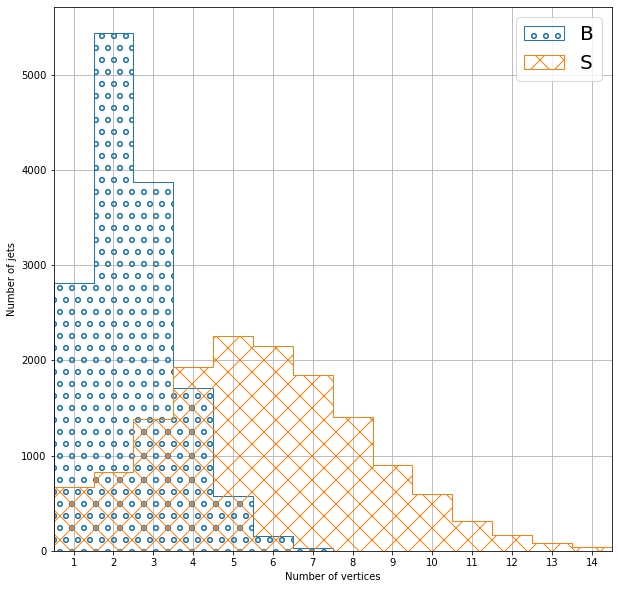

In [80]:
# Number of vertices per jet
fname = "event_vertices_per_jet"
vertex = 'event' # 'event' or 'jet'
x_max = 15
bins = np.arange(0.5,x_max+0.5,1)
ticks =np.arange(1,x_max);
cutoff = 5

if vertex == 'event':
    B = B_event.copy()
    S = S_event.copy()
elif vertex == 'jet':
    B = B_jet.copy()
    S = S_jet.copy()

B.vert_mult.hist(bins=bins,histtype="step",hatch="o")
S.vert_mult.hist(bins=bins,histtype="step",hatch="x")
plt.legend(["B","S"], fontsize=20)
plt.xticks(ticks)
plt.gcf().set_size_inches(10,10)
plt.ylabel("Number of jets")
plt.xlabel("Number of vertices")
plt.xlim([0.5,x_max-0.5])
print("sig efficiency = ", S.vert_mult[S.vert_mult>cutoff].shape[0]/S.shape[0])
print("bkg efficiency = ", B.vert_mult[B.vert_mult>cutoff].shape[0]/B.shape[0])
plt.savefig(fname=analysis_path+fname+".pdf", format='pdf')
plt.savefig(fname=analysis_path+fname+".svg", format='svg')

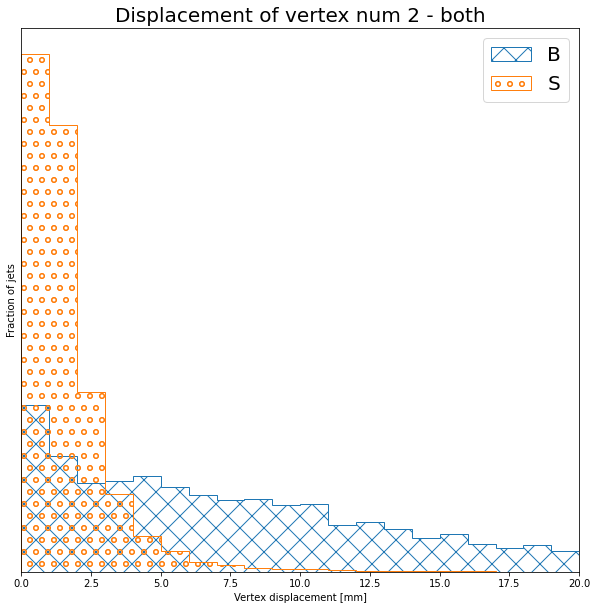

In [58]:
# Vrtex displacement
fname = "jet_secondary_vertex_disp"
vertex = 'jet' # 'event' or 'jet'
n_vert = 2
which = 'both'
sort = 'disp'
range=[0,20]
bins= 20
col_name = 'vert' + str(n_vert) + '_dist'

if vertex == 'event':
    B = B_event.copy()
    S = S_event.copy()
elif vertex == 'jet':
    B = B_jet.copy()
    S = S_jet.copy()

B["vert_dist"] = (B.vert_x**2 + B.vert_y**2).map(np.sqrt)
S["vert_dist"] = (S.vert_x**2 + S.vert_y**2).map(np.sqrt)  

def n_vert_disp(x, n_vert):
    u, ind = np.unique(x, return_index=True)
    if sort == "avr":
        u = u[np.argsort(ind)]
    return u[n_vert-1]
S[col_name] = S[S.vert_mult>=n_vert].vert_dist.apply(n_vert_disp, args=(n_vert,))
B[col_name] = B[B.vert_mult>=n_vert].vert_dist.apply(n_vert_disp, args=(n_vert,))

if which == 'signal':
    plt.hist(B[B.vert_mult>n_vert][col_name], histtype="step",hatch="x", density=True, range=range, bins=bins);
if which == 'background':    
    plt.hist(S[S.vert_mult>n_vert][col_name], histtype="step",hatch="o", density=True, range=range, bins=bins);
if which == 'both':
    plt.hist(B[B.vert_mult>n_vert][col_name], histtype="step",hatch="x", density=True, range=range, bins=bins);
    plt.hist(S[S.vert_mult>n_vert][col_name], histtype="step",hatch="o", density=True, range=range, bins=bins);
    plt.legend(["B","S"], fontsize=20) 

plt.ylabel("Fraction of jets")
plt.xlabel("Vertex displacement [mm]")    
plt.yticks([]);
plt.xlim(range)
plt.title("Displacement of vertex num " + str(n_vert) +  " - " + which, fontsize=20)
plt.gcf().set_size_inches(10,10)
plt.savefig(fname=analysis_path+fname+".pdf", format='pdf')
plt.savefig(fname=analysis_path+fname+".svg", format='svg')

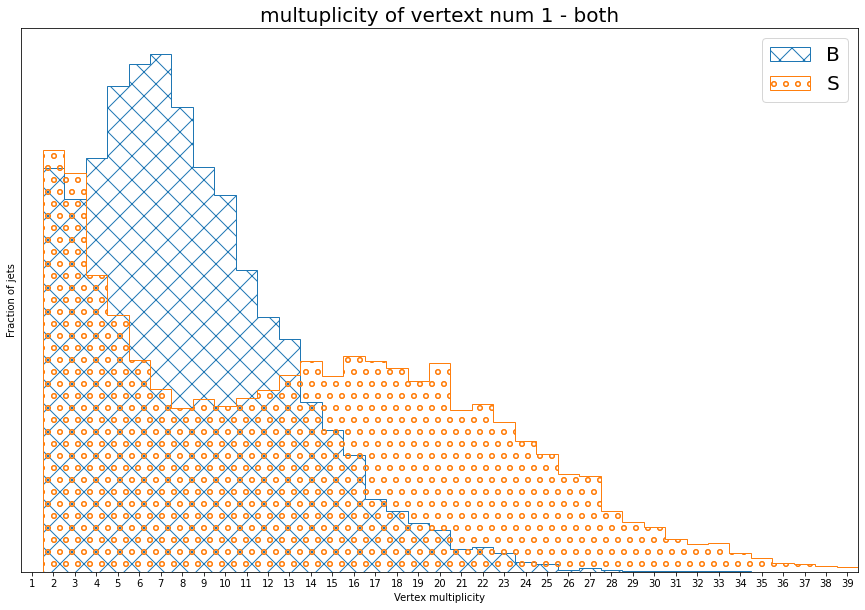

In [83]:
# Vertex multiplicity
save = False
fname = "event_secondary_vertex_multiplicity"
vertex = 'jet' # 'event' or 'jet'
n_vert = 1
which = 'both'
sort = 'disp'
x_max = 40
bins = np.arange(0.5,x_max + 0.5,1)
ticks = np.arange(1,x_max)
col_name = 'vert' + str(n_vert) + '_mult'

if vertex == 'event':
    B = B_event
    S = S_event
elif vertex == 'jet':
    B = B_jet
    S = S_jet

B["vert_dist"] = (B.vert_x**2 + B.vert_y**2).map(np.sqrt)
S["vert_dist"] = (S.vert_x**2 + S.vert_y**2).map(np.sqrt)  
       
def n_vert_mult(x, n_vert):
    u, ind, c = np.unique(x, return_index=True, return_counts=True)
    if sort == 'avr':
        c = c[np.argsort(ind)]
    return c[n_vert-1]
S[col_name] = S[S.vert_mult>=n_vert].vert_dist.apply(n_vert_mult, args=(n_vert,))
B[col_name] = B[B.vert_mult>=n_vert].vert_dist.apply(n_vert_mult, args=(n_vert,))

if which == 'signal':
    plt.hist(B[B.vert_mult>n_vert][col_name], histtype="step",hatch="x", density=True, range=range, bins=bins);
if which == 'background':    
    plt.hist(S[S.vert_mult>n_vert][col_name], histtype="step",hatch="o", density=True, range=range, bins=bins);
if which == 'both':
    plt.hist(B[B.vert_mult>n_vert][col_name], histtype="step",hatch="x", density=True, range=range, bins=bins);
    plt.hist(S[S.vert_mult>n_vert][col_name], histtype="step",hatch="o", density=True, range=range, bins=bins);
    plt.legend(["B","S"], fontsize=20)
plt.yticks([]);
plt.xticks(ticks);
plt.xlim([0.5,x_max-0.5])
plt.ylabel("Fraction of jets")
plt.xlabel("Vertex multiplicity")   
plt.title("multuplicity of vertext num " + str(n_vert) +  " - " + which, fontsize=20)
plt.gcf().set_size_inches(15,10)
if save:
    plt.savefig(fname=analysis_path+fname+".pdf", format='pdf')
    plt.savefig(fname=analysis_path+fname+".svg", format='svg')

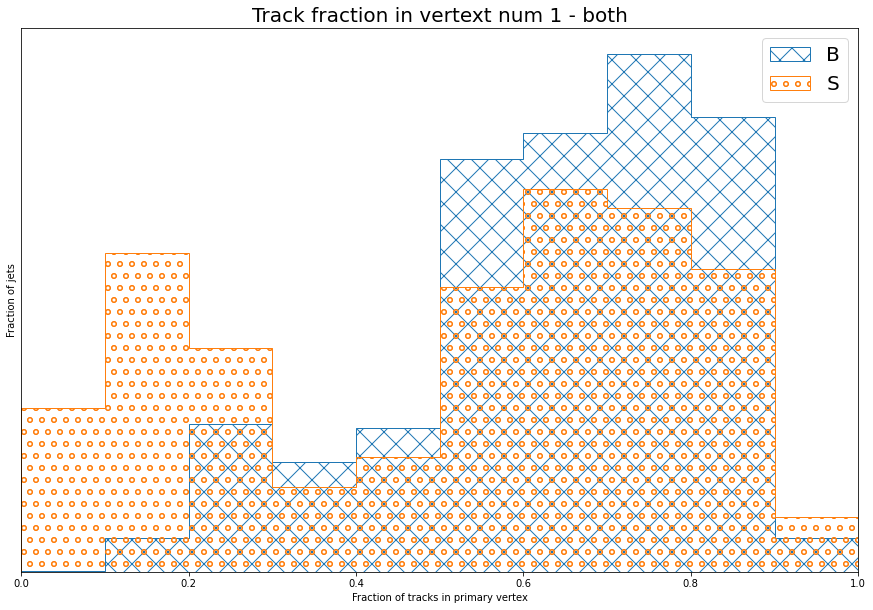

In [79]:
# Precentage in primary vertex
fname = "jet_primary_vertex_fraction"
vertex = 'jet' # 'event' or 'jet'
n_vert = 1
which = 'both'
sort = 'disp'
col_name = 'vert' + str(n_vert) + '_mult'
range = [0,1]
bins = 10

if vertex == 'event':
    B = B_event
    S = S_event
elif vertex == 'jet':
    B = B_jet
    S = S_jet

B["mult"] = B.track_PT.map(lambda x: len(x))
S["mult"] = S.track_PT.map(lambda x: len(x))
           
B["vert_dist"] = (B.vert_x**2 + B.vert_y**2).map(np.sqrt)
S["vert_dist"] = (S.vert_x**2 + S.vert_y**2).map(np.sqrt)  
       
def n_vert_mult(x, n_vert):
    u, ind, c = np.unique(x, return_index=True, return_counts=True)
    if sort == 'avr':
        c = c[np.argsort(ind)]
    return c[n_vert-1]
S[col_name] = S[S.vert_mult>=n_vert].vert_dist.apply(n_vert_mult, args=(n_vert,))
B[col_name] = B[B.vert_mult>=n_vert].vert_dist.apply(n_vert_mult, args=(n_vert,))

S[col_name] = S[col_name]/S.mult
B[col_name] = B[col_name]/B.mult

if which == 'signal':
    plt.hist(B[B.vert_mult>n_vert][col_name], histtype="step",hatch="x", density=True, range=range, bins=bins);
if which == 'background':    
    plt.hist(S[S.vert_mult>n_vert][col_name], histtype="step",hatch="o", density=True, range=range, bins=bins);
if which == 'both':
    plt.hist(B[B.vert_mult>n_vert][col_name], histtype="step",hatch="x", density=True, range=range, bins=bins);
    plt.hist(S[S.vert_mult>n_vert][col_name], histtype="step",hatch="o", density=True, range=range, bins=bins);
    plt.legend(["B","S"], fontsize=20)
plt.yticks([]);
plt.xlim(range)
plt.title("Track fraction in vertext num " + str(n_vert) +  " - " + which, fontsize=20)
plt.ylabel("Fraction of jets")
plt.xlabel("Fraction of tracks in primary vertex")   
plt.gcf().set_size_inches(15,10)
plt.savefig(fname=analysis_path+fname+".pdf", format='pdf')
plt.savefig(fname=analysis_path+fname+".svg", format='svg')

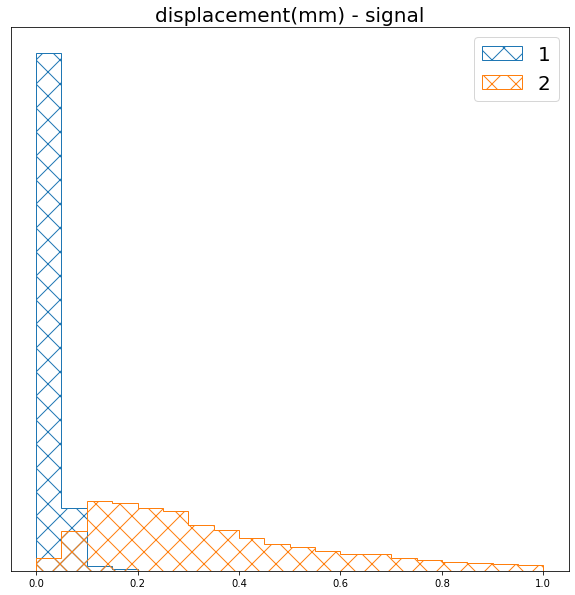

In [99]:
# Pripamry vs secondary vertex displacement
vertex = 'event' # 'event' or 'jet'
n_vert1 = 1
n_vert2 = 2
which = 'signal'
sort = 'disp'
range=[0,1]
bins=20
col_name1 = 'vert'+str(n_vert1) + '_dist'
col_name2 = 'vert'+str(n_vert2) + '_dist'

if vertex == 'event':
    B = B_event
    S = S_event
elif vertex == 'jet':
    B = B_jet
    S = S_jet

B["vert_dist"] = (B.vert_x**2 + B.vert_y**2).map(np.sqrt)
S["vert_dist"] = (S.vert_x**2 + S.vert_y**2).map(np.sqrt)    

def n_vert_disp(x, n_vert):
    u, ind = np.unique(x, return_index=True)
    if sort == 'avr':
        u = u[np.argsort(ind)]
    return u[n_vert-1]    
S[col_name1] = S[S.vert_mult>=n_vert1].vert_dist.apply(n_vert_disp, args=(n_vert1,))
B[col_name1] = B[B.vert_mult>=n_vert1].vert_dist.apply(n_vert_disp, args=(n_vert1,))
S[col_name2] = S[S.vert_mult>=n_vert2].vert_dist.apply(n_vert_disp, args=(n_vert2,))
B[col_name2] = B[B.vert_mult>=n_vert2].vert_dist.apply(n_vert_disp, args=(n_vert2,))

if which == 'signal':
    plt.hist(B[B.vert_mult>n_vert1][col_name1], histtype="step",hatch="x", density=True, range=range, bins=bins);
    plt.hist(B[B.vert_mult>n_vert2][col_name2], histtype="step",hatch="x", density=True, range=range, bins=bins);
if which == 'background':    
    plt.hist(S[S.vert_mult>n_vert1][col_name1], histtype="step",hatch="o", density=True, range=range, bins=bins);
    plt.hist(S[S.vert_mult>n_vert2][col_name2], histtype="step",hatch="o", density=True, range=range, bins=bins);

plt.legend([n_vert1, n_vert2], fontsize=20) 
plt.yticks([]);
plt.title("displacement(mm) - " + which, fontsize=20)
plt.gcf().set_size_inches(10,10)